## Generate XOR Data

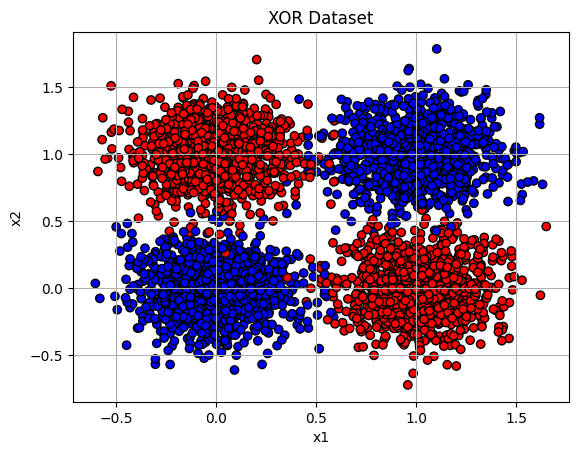

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Create basic XOR data
X = np.array([[0, 0],
              [0, 1],
              [1, 0],
              [1, 1]])

y = np.array([0, 1, 1, 0])

# 2. Optional: Add noise and duplicate for more samples
def generate_xor(n=10000, noise=0.1, seed=42):
    np.random.seed(seed)
    X_big = np.vstack([X for _ in range(n)])
    y_big = np.hstack([y for _ in range(n)])

    # Add small Gaussian noise
    X_noisy = X_big + np.random.normal(0, noise, X_big.shape)
    return X_noisy, y_big

X_noisy, y_noisy = generate_xor(n=1000, noise=0.2)

# 3. Visualize
plt.scatter(X_noisy[:, 0], X_noisy[:, 1], c=y_noisy, cmap='bwr', edgecolors='k')
plt.title("XOR Dataset")
plt.xlabel("x1")
plt.ylabel("x2")
plt.grid(True)
plt.show()


In [20]:
X_noisy.shape, y_noisy.shape

((4000, 2), (4000,))

## Dataset and Data Loader

In [25]:
from torch.utils.data import Dataset, DataLoader
import torch


class XorDataset(Dataset):
    def __init__(self, X, y):
        self.features = torch.tensor(X, dtype=torch.float32)
        self.labels = torch.tensor(y, dtype= torch.float32)

    def __getitem__(self, index):
        x = self.features[index]
        y = self.labels[index]

        return x, y
    
    def __len__(self):
        return len(self.labels)
    

In [29]:
from sklearn.model_selection import train_test_split

X_train,X_test, y_train, y_test =  train_test_split(X_noisy, y_noisy, random_state=42, test_size=0.2, stratify=y_noisy)

X_train,X_val, y_train, y_val =  train_test_split(X_train, y_train, random_state=42, test_size=0.2, stratify=y_train)

In [32]:
X_train.shape, X_val.shape, X_test.shape

((2560, 2), (640, 2), (800, 2))

In [34]:
train_dataset = XorDataset(X_train, y_train)
val_dataset = XorDataset(X_val, y_val)
test_dataset = XorDataset(X_test, y_test)


train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=32,
    shuffle=True
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=32,
    shuffle=False
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=32,
    shuffle=False
)

## Pytorch Model

In [35]:
class XorClassifier(torch.nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.all_layers = torch.nn.Sequential(
            torch.nn.Linear(in_features=num_features, out_features=10),
            torch.nn.ReLU(),
            torch.nn.Linear(10,1),
            torch.nn.Sigmoid()
        )


    def forward(self, x):
        probas = self.all_layers(x)
        return probas

## Training Loop

In [41]:
import torch.nn.functional as F

torch.manual_seed(1)

model = XorClassifier(num_features=X_train.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

num_epochs = 200

for epoch in range(num_epochs):

    model = model.train()
    for batch_idx, (features, class_labels) in enumerate(train_loader):

        probas = model(features)

        loss = F.binary_cross_entropy(probas, class_labels.view(probas.shape))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        ### LOGGING
        if not batch_idx % 20: # log every 20th batch
            print(f'Epoch: {epoch+1:03d}/{num_epochs:03d}'
                   f' | Batch {batch_idx:03d}/{len(train_loader):03d}'
                   f' | Loss: {loss:.2f}')

Epoch: 001/200 | Batch 000/080 | Loss: 0.70
Epoch: 001/200 | Batch 020/080 | Loss: 0.65
Epoch: 001/200 | Batch 040/080 | Loss: 0.57
Epoch: 001/200 | Batch 060/080 | Loss: 0.49
Epoch: 002/200 | Batch 000/080 | Loss: 0.45
Epoch: 002/200 | Batch 020/080 | Loss: 0.35
Epoch: 002/200 | Batch 040/080 | Loss: 0.32
Epoch: 002/200 | Batch 060/080 | Loss: 0.30
Epoch: 003/200 | Batch 000/080 | Loss: 0.22
Epoch: 003/200 | Batch 020/080 | Loss: 0.22
Epoch: 003/200 | Batch 040/080 | Loss: 0.15
Epoch: 003/200 | Batch 060/080 | Loss: 0.19
Epoch: 004/200 | Batch 000/080 | Loss: 0.29
Epoch: 004/200 | Batch 020/080 | Loss: 0.17
Epoch: 004/200 | Batch 040/080 | Loss: 0.08
Epoch: 004/200 | Batch 060/080 | Loss: 0.07
Epoch: 005/200 | Batch 000/080 | Loss: 0.15
Epoch: 005/200 | Batch 020/080 | Loss: 0.18
Epoch: 005/200 | Batch 040/080 | Loss: 0.21
Epoch: 005/200 | Batch 060/080 | Loss: 0.12
Epoch: 006/200 | Batch 000/080 | Loss: 0.15
Epoch: 006/200 | Batch 020/080 | Loss: 0.17
Epoch: 006/200 | Batch 040/080 |

In [42]:
def compute_accuracy(model, dataloader):

    model = model.eval()
    
    correct = 0.0
    total_examples = 0
    
    for idx, (features, class_labels) in enumerate(dataloader):
        
        with torch.no_grad():
            probas = model(features)
        
        pred = torch.where(probas > 0.5, 1, 0)
        lab = class_labels.view(pred.shape).to(pred.dtype)

        compare = lab == pred
        correct += torch.sum(compare)
        total_examples += len(compare)

    return correct / total_examples

In [43]:
train_acc = compute_accuracy(model, train_loader)
print(f"Accuracy: {train_acc*100:.2f}%")

Accuracy: 94.88%


In [47]:
test_acc = compute_accuracy(model, test_loader)
print(f"Accuracy: {test_acc*100:.2f}%")

Accuracy: 94.62%


## Decision Boundary

In [48]:
def plot_decision_boundary(model, X, y):
    model.eval()
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 300),
        np.linspace(y_min, y_max, 300)
    )
    grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
    with torch.no_grad():
        probs = model(grid).reshape(xx.shape)

    plt.contourf(xx, yy, probs, levels=50, cmap="bwr", alpha=0.6)
    plt.scatter(X[:, 0], X[:, 1], c=y.squeeze(), cmap="bwr", edgecolors='k')
    plt.title("XOR Decision Boundary")
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.grid(True)
    plt.savefig("decision_boundary.png")
    print("Saved plot as decision_boundary.png")

Saved plot as decision_boundary.png


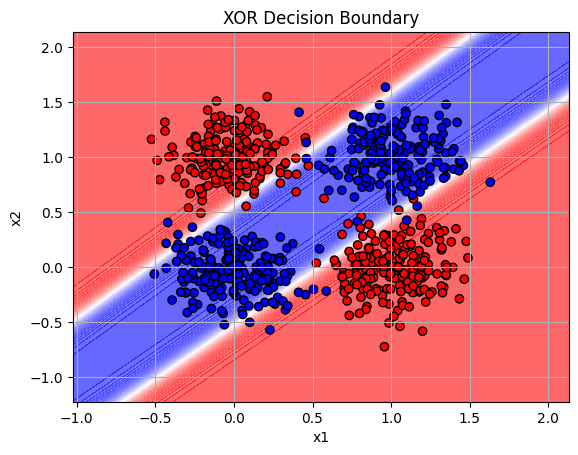

In [49]:
plot_decision_boundary(model, X_test, y_test)